In [1]:
import torch
from torch_geometric.nn import MessagePassing

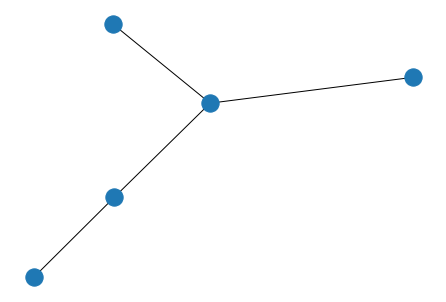

In [2]:
# Generate graph
import networkx as nx
from torch_geometric.data import Data
edge_index = torch.tensor([[0, 1, 2, 0, 3, 2, 4, 2],
                           [1, 0, 0, 2, 2, 3, 2, 4]], dtype=torch.long)
x = torch.tensor([[0, 2, 3], [9, 2, 3], [8, 2, 3], [7, 2, 3], [6, 2, 3]], dtype=torch.float32)
data = Data(x, edge_index)
graph = nx.Graph()
graph.add_edges_from(edge_index.transpose(0, 1).numpy())
nx.draw(graph)

In [3]:
from torch_geometric.nn import MessagePassing
from torch.nn import Linear, Parameter
import torch.nn.functional as F
from torch_geometric.utils import softmax

class GATLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GATLayer, self).__init__(aggr='add')
        
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.a_left = Linear(in_channels, out_channels)
        self.a_right = Linear(in_channels, out_channels)
        self.lin = Linear(in_channels, out_channels)
        self.alpha = Parameter(torch.Tensor(1, 1, out_channels))


    def forward(self, x, edge_index):
        # 1. Calculate X transform
        print(x.shape, x.dtype)
        x_left = x_right = self.lin(x).view(-1, 1, self.out_channels)
        a = x_left * self.alpha

        return self.propagate(edge_index, x=(x_left, x_right), a=(a, a))

    def message(self, x_j, x_i, index, a_i, a_j):
        # Generate new features
        # Calculate attention
        a = a_i + a_j

        a = F.leaky_relu(a, 0.2)
        a = softmax(a, index)

        return x_j * a.unsqueeze(-1)


conv1 = GATLayer(3, 1)
_ = conv1(x, edge_index)

torch.Size([5, 3]) torch.float32


In [4]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAT, self).__init__()
        self.conv1 = GATLayer(in_channels, out_channels)

    def forward(self, x, edge_index):
        return F.softmax(self.conv1(x, edge_index))


In [8]:
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

dataset = Planetoid('./data', 'Cora')
train_loader = DataLoader(dataset, batch_size=1)

In [9]:
dataset[0]

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(dataset.num_node_features, dataset.num_classes).to(device)
data = dataset[0].to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

torch.Size([2708, 1433]) torch.float32


RuntimeError: CUDA out of memory. Tried to allocate 20.34 GiB (GPU 0; 2.00 GiB total capacity; 17.84 MiB already allocated; 1.34 GiB free; 20.00 MiB reserved in total by PyTorch)

In [68]:
n = 3
f = 10
ff = 5
a = torch.rand(n, 1).T
x = torch.rand(ff, f)
h = torch.rand(f, n)
print(x @ h)
print(x.dim())
print(a)

tensor([[2.1851, 2.0249, 1.8470],
        [2.4945, 1.4813, 2.1242],
        [2.9714, 2.8518, 2.6886],
        [2.6581, 2.8853, 3.2042],
        [2.4496, 2.0611, 2.8559]])
2
tensor([[0.0863, 0.5627, 0.2210]])
